# Goal

The goal of this notebook is to compare the efficiency, measured in flops per watt, of the different GPU frequencies that the AGX allows. Also comparing any difference running the tests with tensor cores enabled and disabled.

In [1]:
# Data Preprocessing

import os

path = "./data/AGX/square_all_frequency/"
files = os.listdir(path)

data = []

for file_name in files:
    temp = {
        # Inputs
        "device": "",
        "datatype": "",
        "matrix_size": -1,
        "tensor": None,
        "gpu_frequency": -1,

        # Results
        "power_usage": [],
        "flops": -1,
        
        # Calculated Results
        "avg_power": -1,
        "flops_per_watt": -1
    }
    with open(path+file_name, "r") as f:
        temp['device'], temp['datatype'], temp['matrix_size'], temp['tensor'], temp['gpu_frequency'] = file_name.split(".")[0].split("-")
        temp['matrix_size'] = float(temp['matrix_size'])
        temp['tensor'] = True if temp['tensor'].lower() == "tensor" else False
        temp['gpu_frequency'] = float(temp['gpu_frequency'])

        file_data = f.readlines()

        _, temp['power_usage'] = zip(*[d.strip().split(",") for d in file_data[:-1]])
        temp['power_usage'] = list(map(float, temp['power_usage']))
        temp['avg_power'] = sum(temp['power_usage'])/len(temp['power_usage'])

        temp['flops'] = float(file_data[-1])

        temp['flops_per_watt'] = temp['flops'] / temp['avg_power']
    
    data.append(temp)

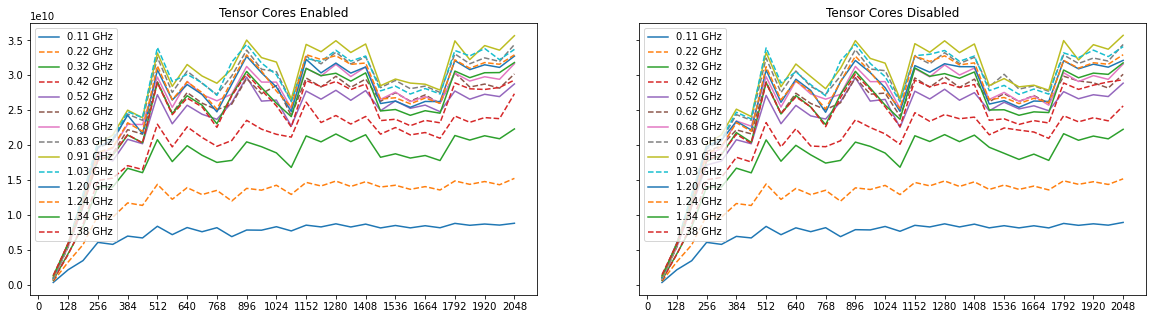

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
plt.ion()

datatype = widgets.Dropdown(options=["half", "float", "double"], value="float", description="Datatype")
y_opt = widgets.Dropdown(options=["avg_power", "flops", "flops_per_watt"], value="flops_per_watt", description="y axis")

output = widgets.Output()

fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True, sharex=True)

search_tensor = {
    "datatype": datatype.value,
    "gpu_frequency": 0,
    "tensor": True
}

search_nontensor = {
    "datatype": datatype.value,
    "gpu_frequency": 0,
    "tensor": False
}

search_x = "matrix_size"
search_y = y_opt.value

def refresh_values():
    for idx, f in enumerate([114750000, 216750000, 318750000, 420750000, 522750000, 624750000, 675750000, 828750000, 905250000, 1032750000, 1198500000, 1236750000, 1338750000, 1377000000]):
        search_tensor["gpu_frequency"] = f
        search_nontensor["gpu_frequency"] = f
        filtered_tensor = [d for d in data if search_tensor.items() <= d.items()]
        filtered_nontensor = [d for d in data if search_nontensor.items() <= d.items()]
        x, y = [[],[]], [[],[]]
        x[0], y[0] = zip(*sorted([(r[search_x], r[search_y]) for r in filtered_tensor], key=lambda d : d[0]))
        x[1], y[1] = zip(*sorted([(r[search_x], r[search_y]) for r in filtered_nontensor], key=lambda d : d[0]))
        for i in range(2):
            ax[i].plot(x[i], y[i], label=f"{f/1e9:.2f} GHz", linestyle='--' if idx % 2 else '-')
            ax[i].set_title(f"Tensor Cores {'Enabled' if i == 0 else 'Disabled'}")
            ax[i].legend(loc="upper left")
            ax[i].set_xticks(np.arange(0, 2049, 128))

def change_datatype(change):
    search_tensor["datatype"] = change["new"]
    search_nontensor["datatype"] = change["new"]
    ax[0].clear()
    ax[1].clear()
    refresh_values()

def update_y(change):
    global search_y
    search_y = change["new"]
    ax[0].clear()
    ax[1].clear()
    refresh_values()

y_opt.observe(update_y, names="value")
datatype.observe(change_datatype, names="value")

display(
    widgets.HBox([
        widgets.VBox([datatype]),
        widgets.VBox([y_opt]),
        widgets.VBox([output])
    ])
)

refresh_values()

<BarContainer object of 14 artists>

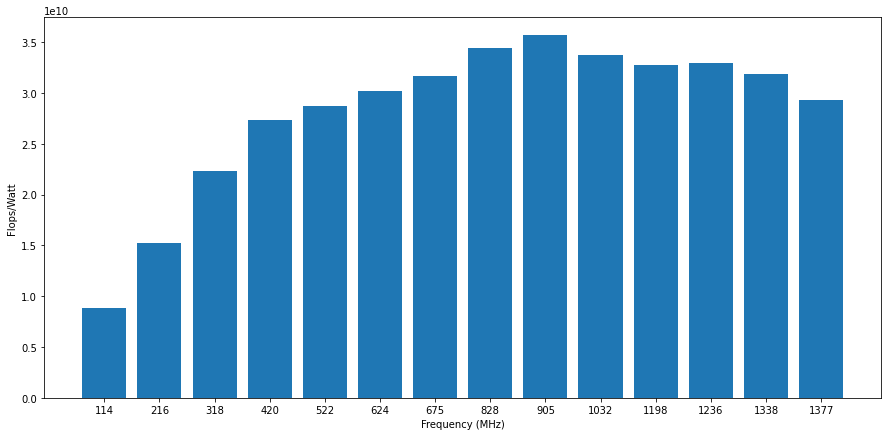

In [5]:
# TODO: Graph Flops/Watt Relative to Max frequency

import matplotlib.figure as figure

matrix_size = 2048

search = {
    "datatype": "float",
    "matrix_size": matrix_size,
    "tensor": True,
    # "gpu_frequency": -1 // This is the x-axis
}

filtered = [d for d in data if search.items() <= d.items()]
x, y = zip(*sorted([(d['gpu_frequency'], d['flops_per_watt']) for d in filtered], key=lambda d : d[0]))


fig, ax = plt.subplots(figsize=(15, 7))
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Flops/Watt")

plt.bar([str(xx) for xx in x], y, bottom=0, tick_label=[int(tx/1e6) for tx in x])
